In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import math
from math import floor, ceil

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'



In [2]:
def nash_eq(p, gamma, rng):
    mat = np.full((len(gamma),len(gamma)), np.nan)
    for d in rng:
        cond1 = gamma / ((1-p)*p) >= (1 - p/d)**d/(d+1)
        cond2 = gamma / ((1-p)*p) <= (1 - p/d)**(d-1)/d
        utils = 1 - (1-p) * (1 - p/d)**d - gamma*d
        utils[np.invert(cond1) | np.invert(cond2)] = np.nan
        mat[np.isnan(mat)] = utils[np.isnan(mat)]
    mat = np.maximum(p, mat)
    mat[np.isnan(mat)] = p if type(p) == float else p[np.isnan(mat)]
    return mat

def nash_eq_lb(K, p, gamma):
    return nash_eq(p, gamma, np.arange(K, 0, -1))

def nash_eq_ub(K, p, gamma):
    return nash_eq(p, gamma, np.arange(1, K, 1))


In [3]:
def dfpne_g_d(g, b, gamma, d, bounds="heuristic", util="simple"):
    if d == 0:
        cond1 = True
        cond2 = g*(1-g) <= gamma
        if type(g) == float:
            utils = np.full((len(b), len(b)), g)
        else:
            utils = g.copy()
    elif bounds == "heuristic":
        cond1 = gamma / ((1-g)*g) <= (1 - g/d)**(d-1)/d
        cond2 = (1 - g/d)**d/(d+1) <= gamma / ((1-g)*g) 
        utils = 1 - (1-g) * (1 - g/d)**d - gamma*d
    elif bounds == "proven":
        cond1 = gamma / ((1-g)*g) <= (1 - g/(d+1))**(d-1) / np.maximum(d-g/b, 1)
        cond2 = (1 - g/max(d-1, 1))**d / (d+1+g/b) <= gamma / ((1-g)*g)
        utils = 1 - (1-g)*(1 - g/(d+1))**d - gamma * d
    elif bounds == "improved":
        # no sever: 
        djb_range_lower = np.ceil(b/g*d-1).astype(int)
        djb_range_upper = (np.floor(b/g*(d+1))+1).astype(int)
        djb_range_lower_min = np.min(djb_range_lower)
        djb_range_upper_max = np.max(djb_range_upper)
        cond1b = False
        for dj in range(max(djb_range_lower_min, 1), djb_range_upper_max+1):
            cond1b = np.logical_or(cond1b, gamma / ((1-g)*b) <= 1/dj*(1-b/dj)**(d-1))# j in B
        djg_range = range(max(d-1, 1), d+2)
        cond1g = gamma / ((1-g)*g) <= np.maximum.reduce([1/dj*(1-g/dj)**(d-1) for dj in djg_range])# j in G
        cond1 = np.logical_or(cond1b, cond1g)
        # no create: assumption is that there exists someone unconnected of same degree. true for i in S?
        cond2 = 1 / d * (1 - g/max(d-1, 1))**d <= gamma / ((1-g)*g) 
        # utils
        if util == "simple":
            utils = 1 - (1-g)*np.exp(-g) - gamma * d
        else:
            utils = 1 - (1-g)*(1 - g/(d+1))**d - gamma*d  
    utils[np.invert(cond1) | np.invert(cond2)] = np.nan
    return utils

def dfpne_g(g, b, gamma, rng, bounds="heuristic", util="simple"):
    mat = np.fmin.reduce([dfpne_g_d(g, b, gamma, d, bounds, util) for d in rng])
    return mat

def dfpne_b_d(g, b, gamma, d, bounds="heuristic", util="simple"):
    if d == 0:
        # can't sever
        cond1 = True
        # no create
        cond2 = (1-b)*b <= gamma
        utils = b.copy()
    elif bounds == "heuristic":
        cond1 = gamma / ((1-b)*b) >= (1 - b/d)**d/(d+1)
        cond2 = gamma / ((1-b)*b) <= (1 - b/d)**(d-1)/d
        utils = 1 - (1-b) * (1 - b/d)**d - gamma*d
    elif bounds == "proven":
        cond1 = gamma / ((1-b)*b) <= (1 - b/(d+1))**(d-1) / max(d - 1, 1)
        cond2 = gamma / ((1-b)*b) >= (1 - b/(np.maximum(d-b/g, 1)))**d / (d + 2)
        utils = 1 - (1-b)*(1 - b/(max(d-1, 1)))**d - gamma * d
    elif bounds == "improved":
        # no sever:
        dib_range = range(max(d-1, 1), d+2)
        cond1b = gamma / ((1-b)*b) <= np.maximum.reduce([1/di*(1-b/di)**(d-1) for di in dib_range])
        dig_range_lower = np.ceil(g/b*d-1).astype(int)
        dig_range_upper = (np.floor(g/b*(d+1))+1).astype(int)
        dig_range_lower_min = np.min(dig_range_lower)
        dig_range_upper_max = np.max(dig_range_upper)
        cond1g = False
        for di in range(max(dig_range_lower_min, 1), dig_range_upper_max+1):
            cond1g = np.logical_or(cond1g, gamma / ((1-b)*g) <= 1/di*(1-g/di)**(d-1))
        cond1 = np.logical_or(cond1b, cond1g)
        # no create:
        cond2 = 1 / d * (1 - b/max(d-1, 1))**d <= gamma / ((1-b)*b)
        if util == "simple":
            utils = 1 - (1-b) * np.exp(-b) - gamma * d
        else:
            utils = 1 - (1-b)*(1 - b/(max(d-1, 1)))**d - gamma*d
    utils[np.invert(cond1) | np.invert(cond2)] = np.nan
    return utils
    
def dfpne_b(g, b, gamma, rng, bounds="heuristic", util="simple"):
    mat = np.fmax.reduce([dfpne_b_d(g, b, gamma, d, bounds, util) for d in rng])
    return mat
    

In [4]:
# Plotting Function
def plot_contours(K, fontsize, levels, ticks, tick_labs, bounds="heuristic", util="simple", gammamax=0.1, mu_high = 1/2, factor_max = 20, title=""):
    epsilon = 0.0001
    grid_size = 50
    factors = np.linspace(1, factor_max, grid_size)
    gamma = np.linspace(0.01 + epsilon, gammamax - epsilon, grid_size)
    Gamma, Factors = np.meshgrid(gamma, factors)
    #Z = nash_eq_lb(K, mu_high, Gamma) / nash_eq_ub(K, mu_high / Factors, Gamma) / Factors
    Z = dfpne_g(mu_high, mu_high / Factors, Gamma, np.arange(K, -1, -1), bounds, util) / dfpne_b(mu_high, mu_high / Factors, Gamma, np.arange(0, K, 1), bounds, util) / Factors

    fig = plt.figure(figsize=(6, 3), dpi=600)
    ax = fig.add_subplot()
    contour = ax.contourf(Factors, Gamma, Z, levels=levels, cmap=cm.turbo)
    ax.set_xlabel(r"Exogenous opportunity ratio $(\mu_G / \mu_B)$, setting $\mu_G$ = " + f"${mu_high * 2 - 1 + (1-mu_high)}$", fontsize=fontsize)
    ax.set_ylabel(r"Connection cost $(\gamma)$", fontsize=fontsize)
    ax.set_title("")
    cbar = fig.colorbar(contour, ticks=ticks)
    cbar.ax.set_yticklabels(tick_labs)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar.ax.tick_params(axis='both', which='major', labelsize=fontsize)
    for spine in ax.spines.values():
        spine.set_visible(False)
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)
    ax.plot(factors, [mu_high*(1-mu_high) for _ in range(grid_size)], color="black")
    ax.plot(factors, mu_high / factors * (1-mu_high / factors), color="black")
    ax.set_ylim((epsilon, gammamax))
    fig.suptitle(title)
    return fig, ax

# The network makes inequality worse in equilibrium (if the platform does not intervene)

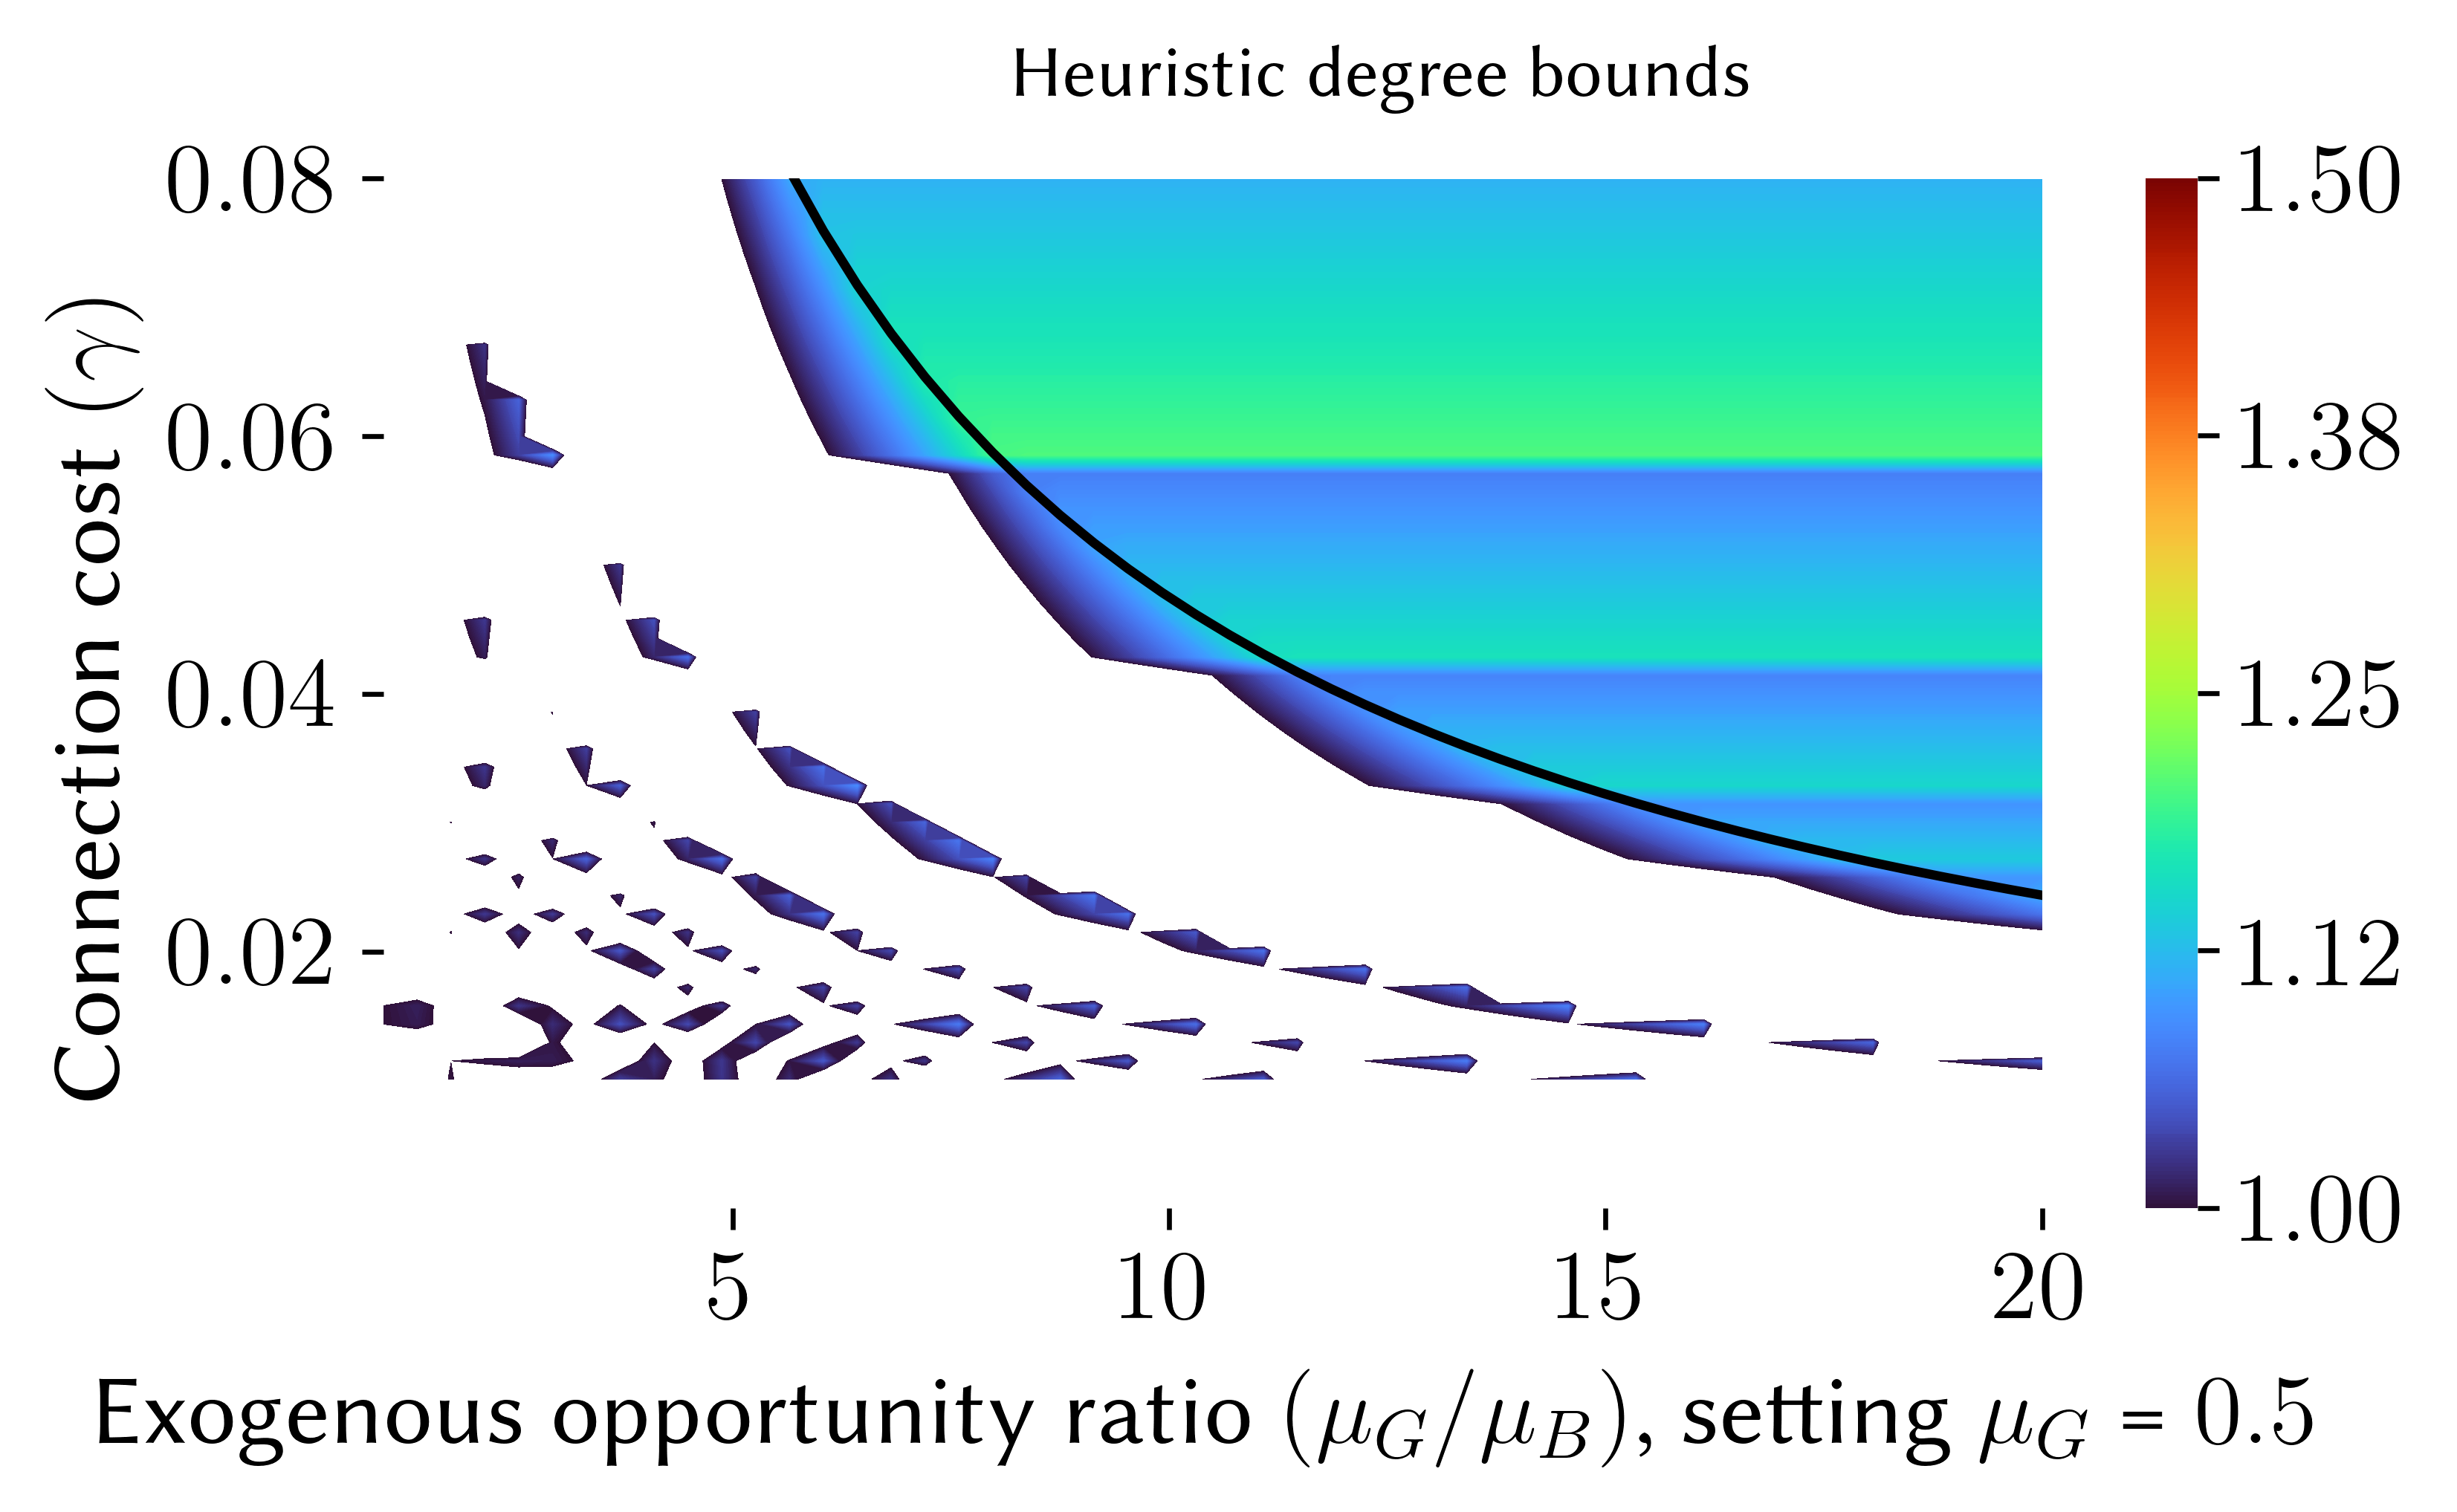

In [5]:
K = 250
fontsize = 16
poa_max = 1.5
levels = np.linspace(1, poa_max, K)
ticks = np.linspace(1, poa_max, 5)
tick_labs = [f"${f:.2f}$" for f in ticks]
bounds = "heuristic"

fig, ax = plot_contours(K, fontsize, levels, ticks, tick_labs, mu_high=0.5, gammamax=0.08, factor_max=20, bounds=bounds, title="Heuristic degree bounds")
#plt.savefig("oblivious_edge_costs_lb.png", bbox_inches='tight')


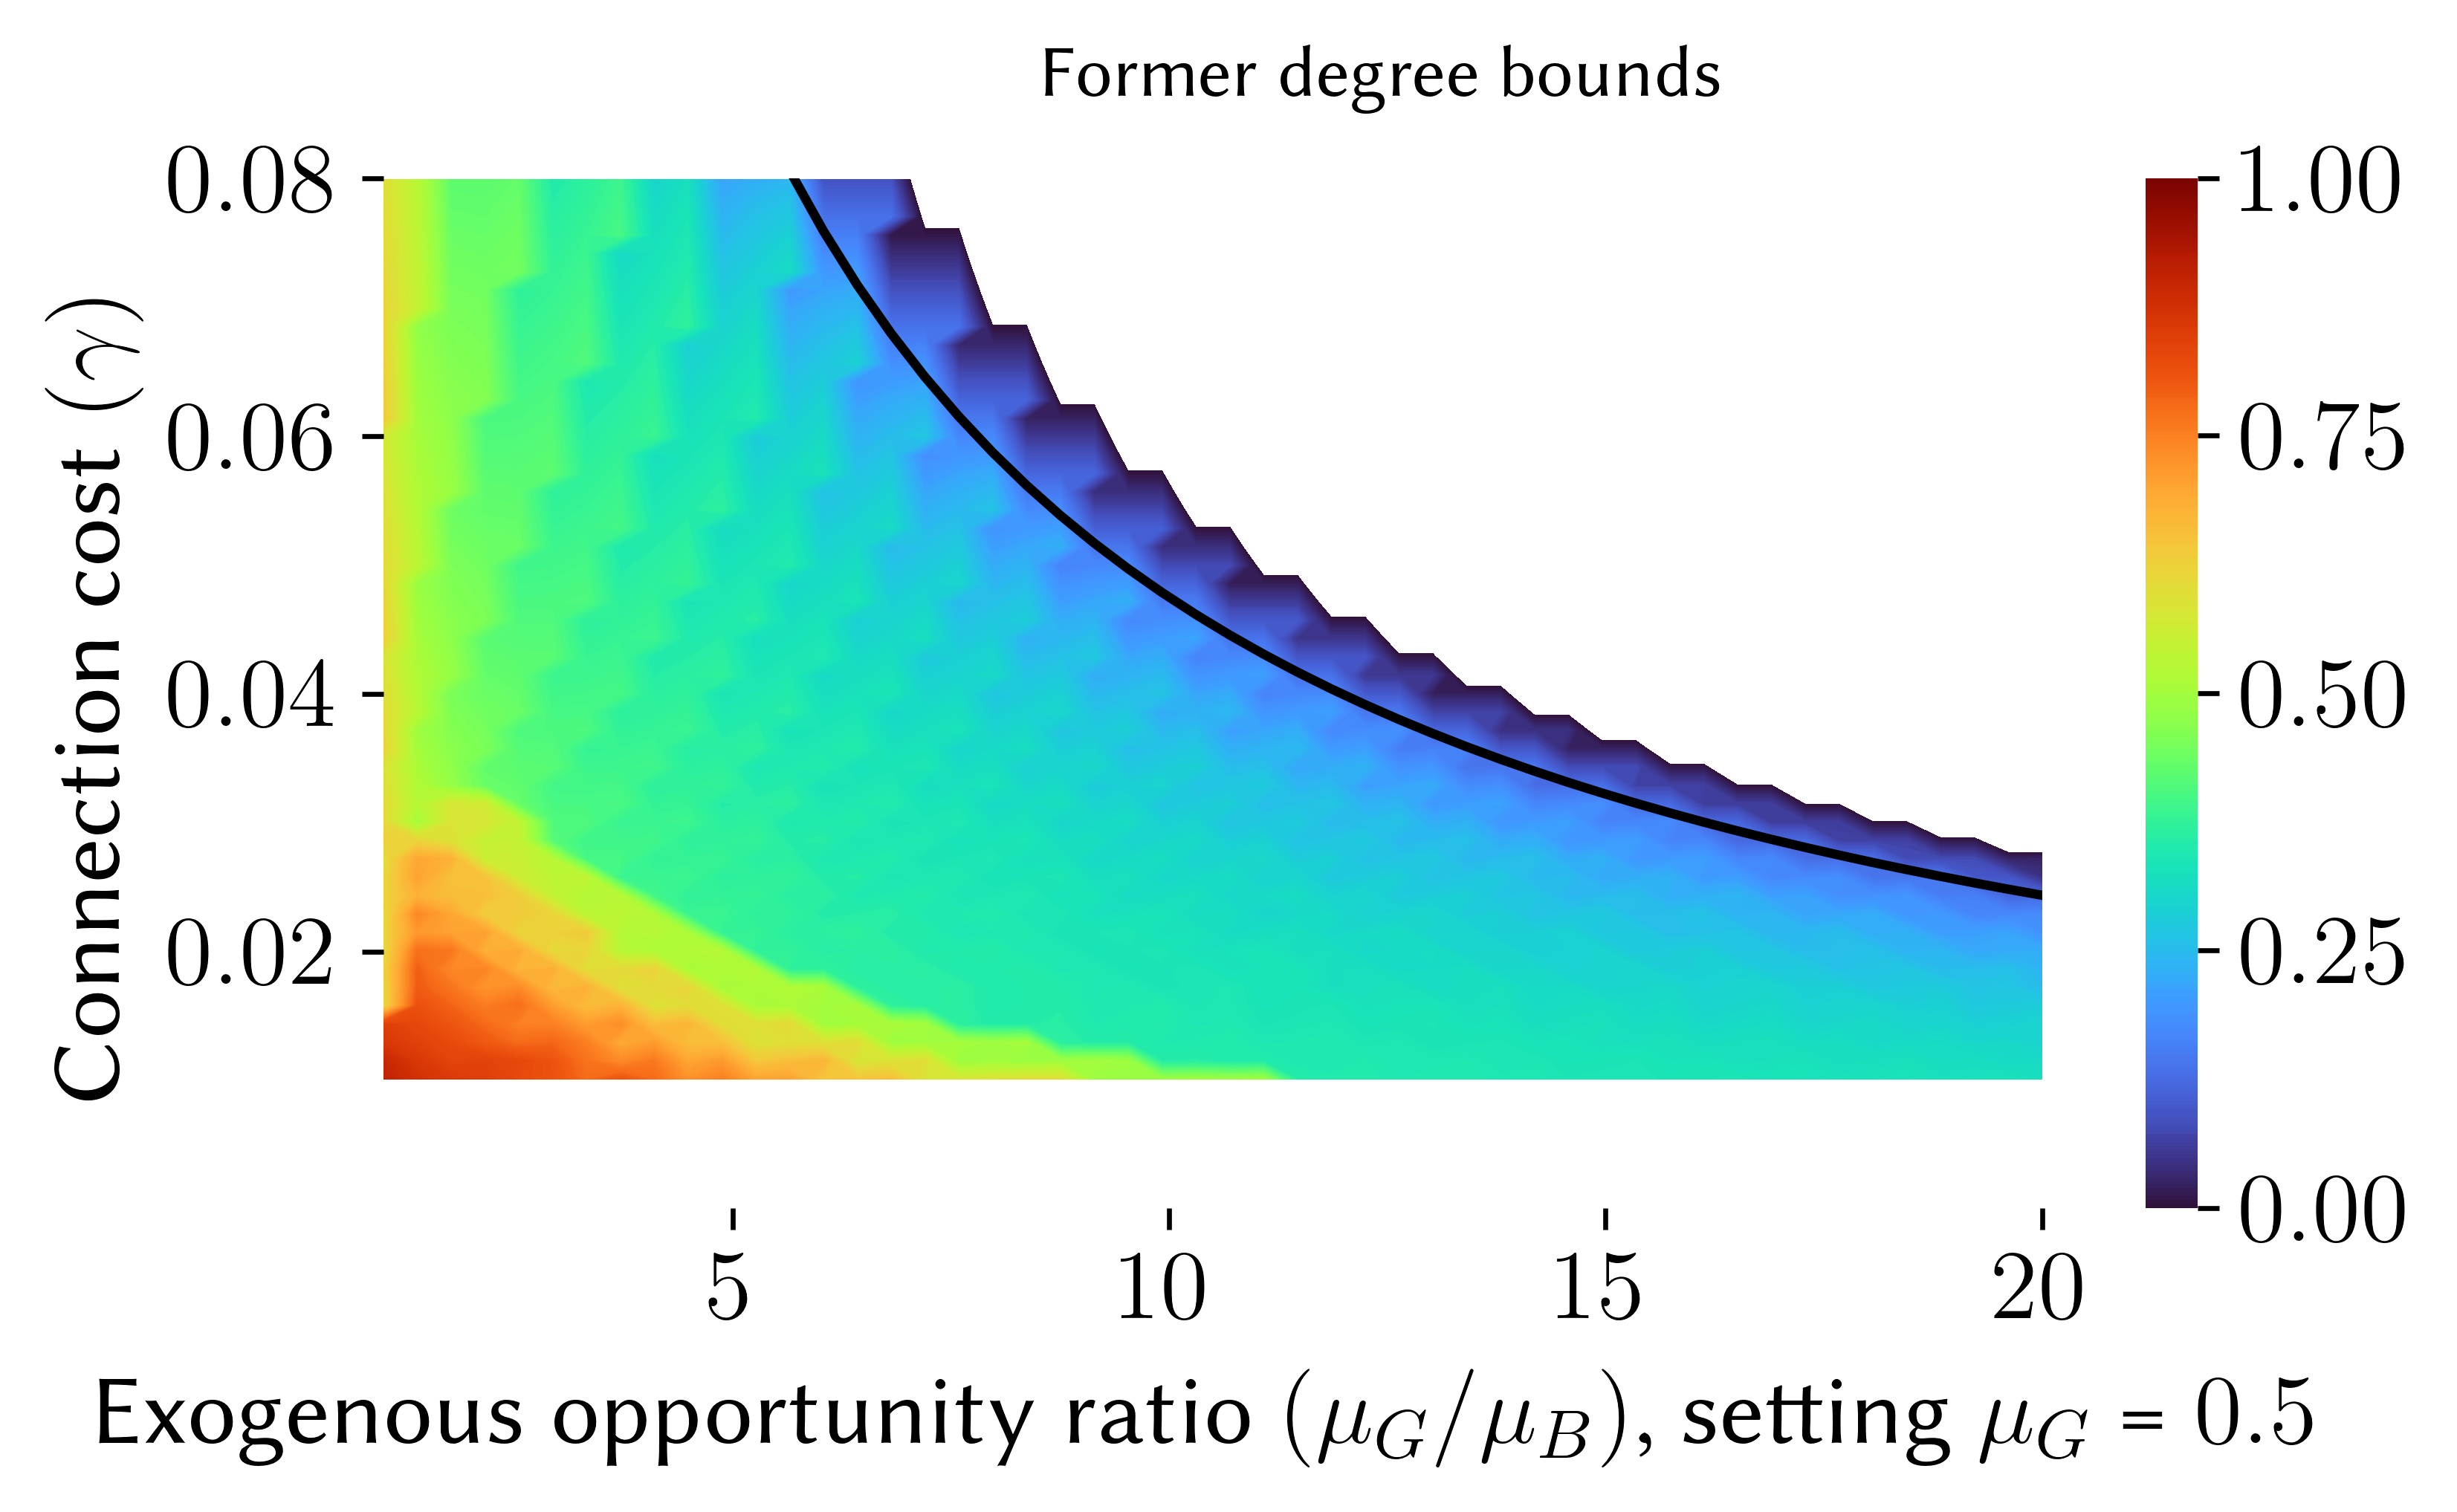

In [6]:
K = 250
fontsize = 16
poa_max = 1
levels = np.linspace(0, poa_max, K)
ticks = np.linspace(0, poa_max, 5)
tick_labs = [f"${f:.2f}$" for f in ticks]
bounds = "proven"

fig, ax = plot_contours(K, fontsize, levels, ticks, tick_labs, mu_high=0.5, gammamax=0.08, factor_max = 20, bounds=bounds, title="Former degree bounds")
#plt.savefig("oblivious_edge_costs_lb.png", bbox_inches='tight')

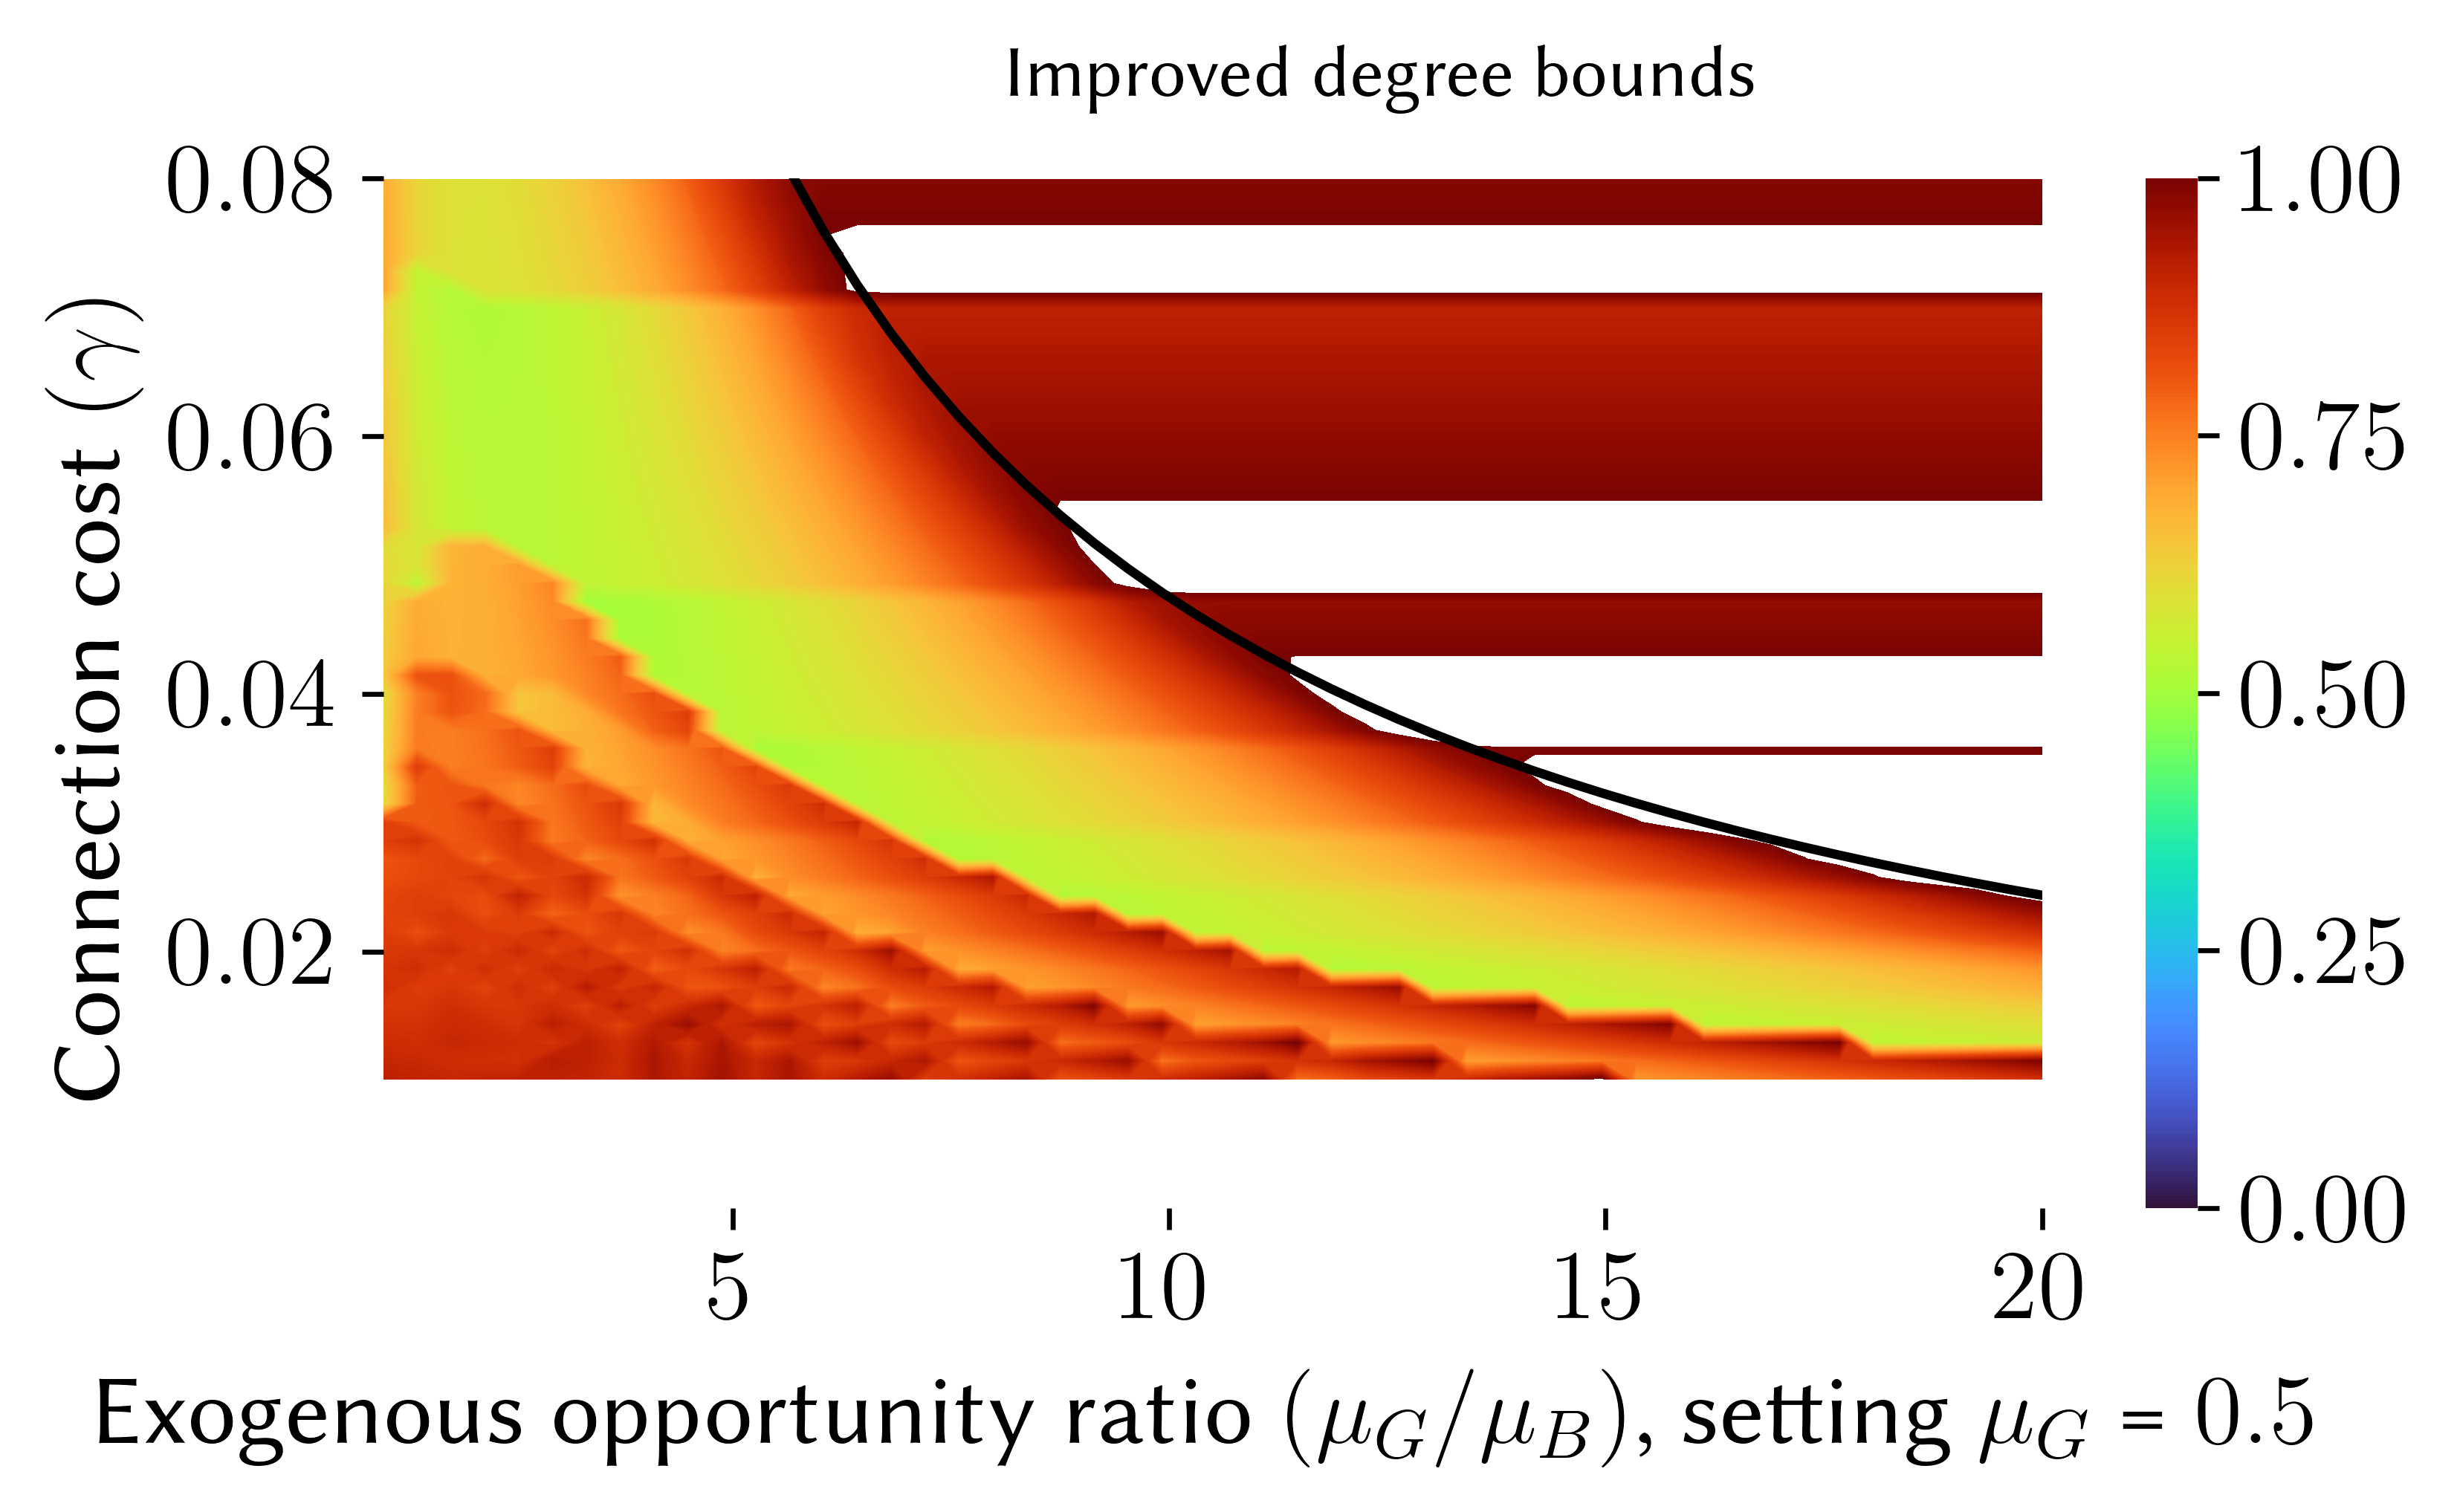

In [7]:
K = 250
fontsize = 16
poa_max = 1
levels = np.linspace(0, poa_max, K)
ticks = np.linspace(0, poa_max, 5)
tick_labs = [f"${f:.2f}$" for f in ticks]
bounds = "improved"

fig, ax = plot_contours(K, fontsize, levels, ticks, tick_labs, mu_high=0.5, gammamax=0.08, bounds=bounds, factor_max=20, util="complex", title="Improved degree bounds")
#plt.savefig("oblivious_edge_costs_lb.png", bbox_inches='tight')

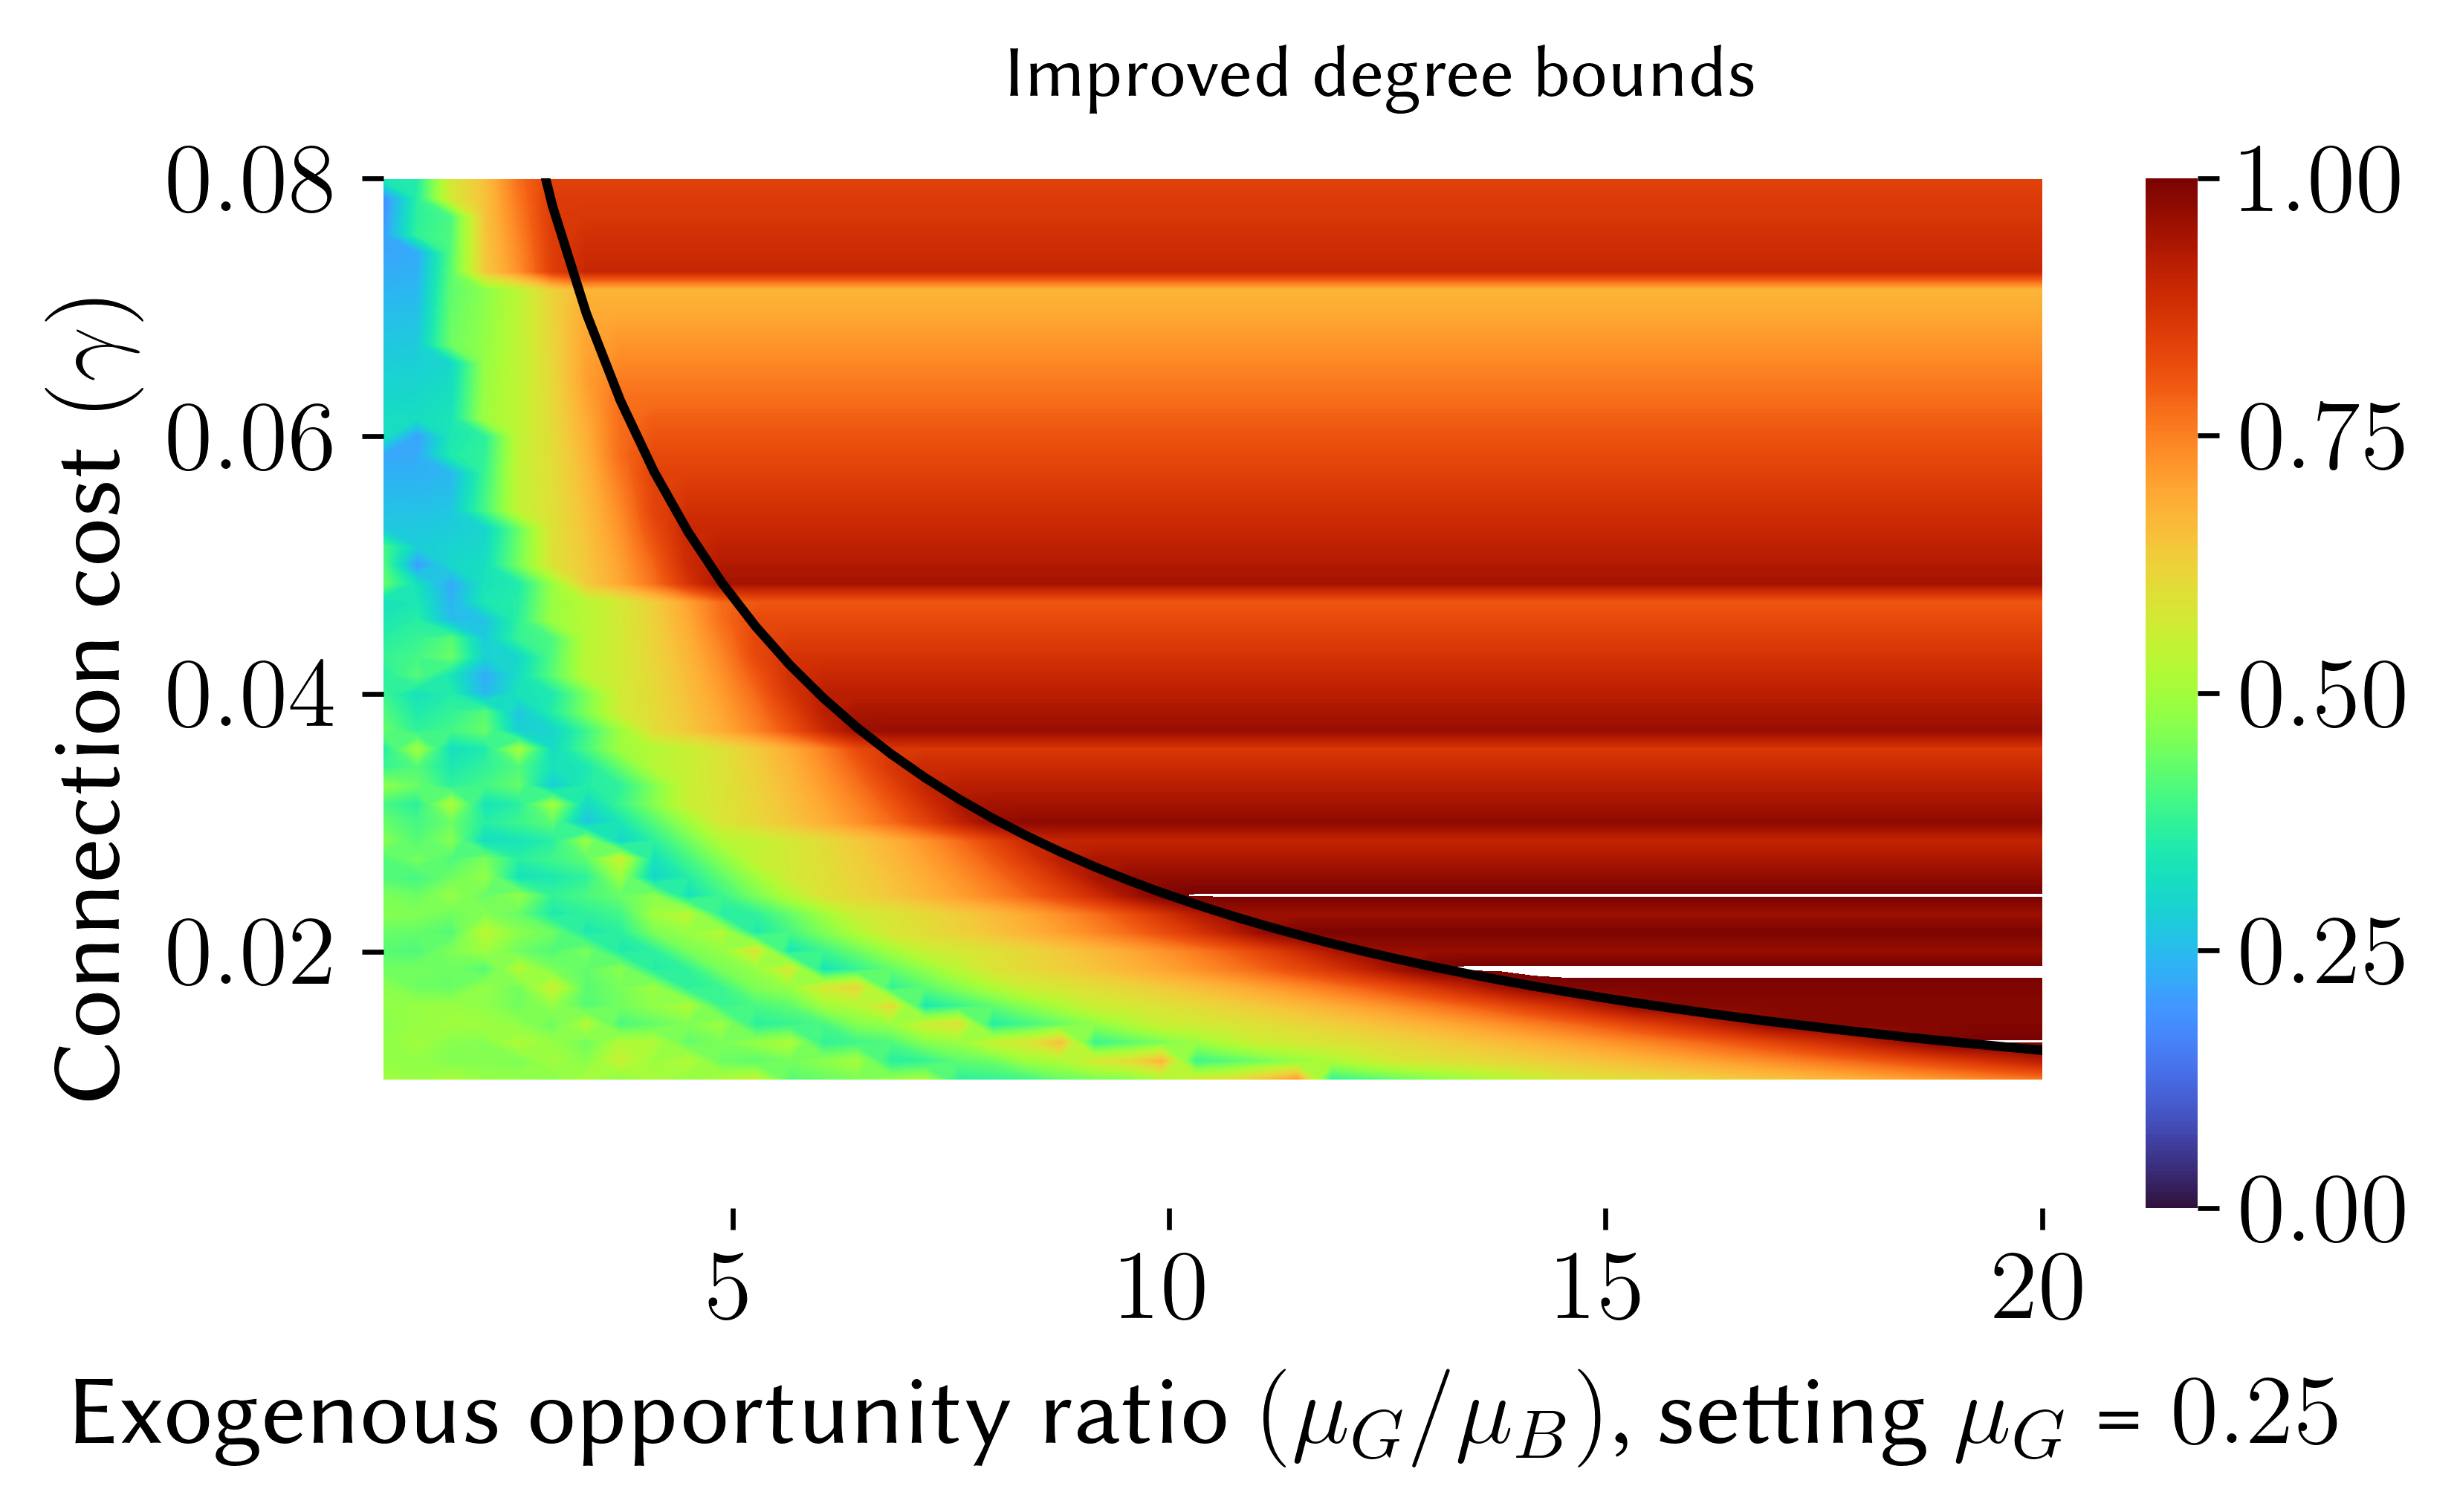

In [8]:
K = 250
fontsize = 16
poa_max = 1
levels = np.linspace(0, poa_max, K)
ticks = np.linspace(0, poa_max, 5)
tick_labs = [f"${f:.2f}$" for f in ticks]
bounds = "improved"

fig, ax = plot_contours(K, fontsize, levels, ticks, tick_labs, mu_high=0.25, gammamax=0.08, bounds=bounds, factor_max=20, util="complex", title="Improved degree bounds")
#plt.savefig("oblivious_edge_costs_lb.png", bbox_inches='tight')

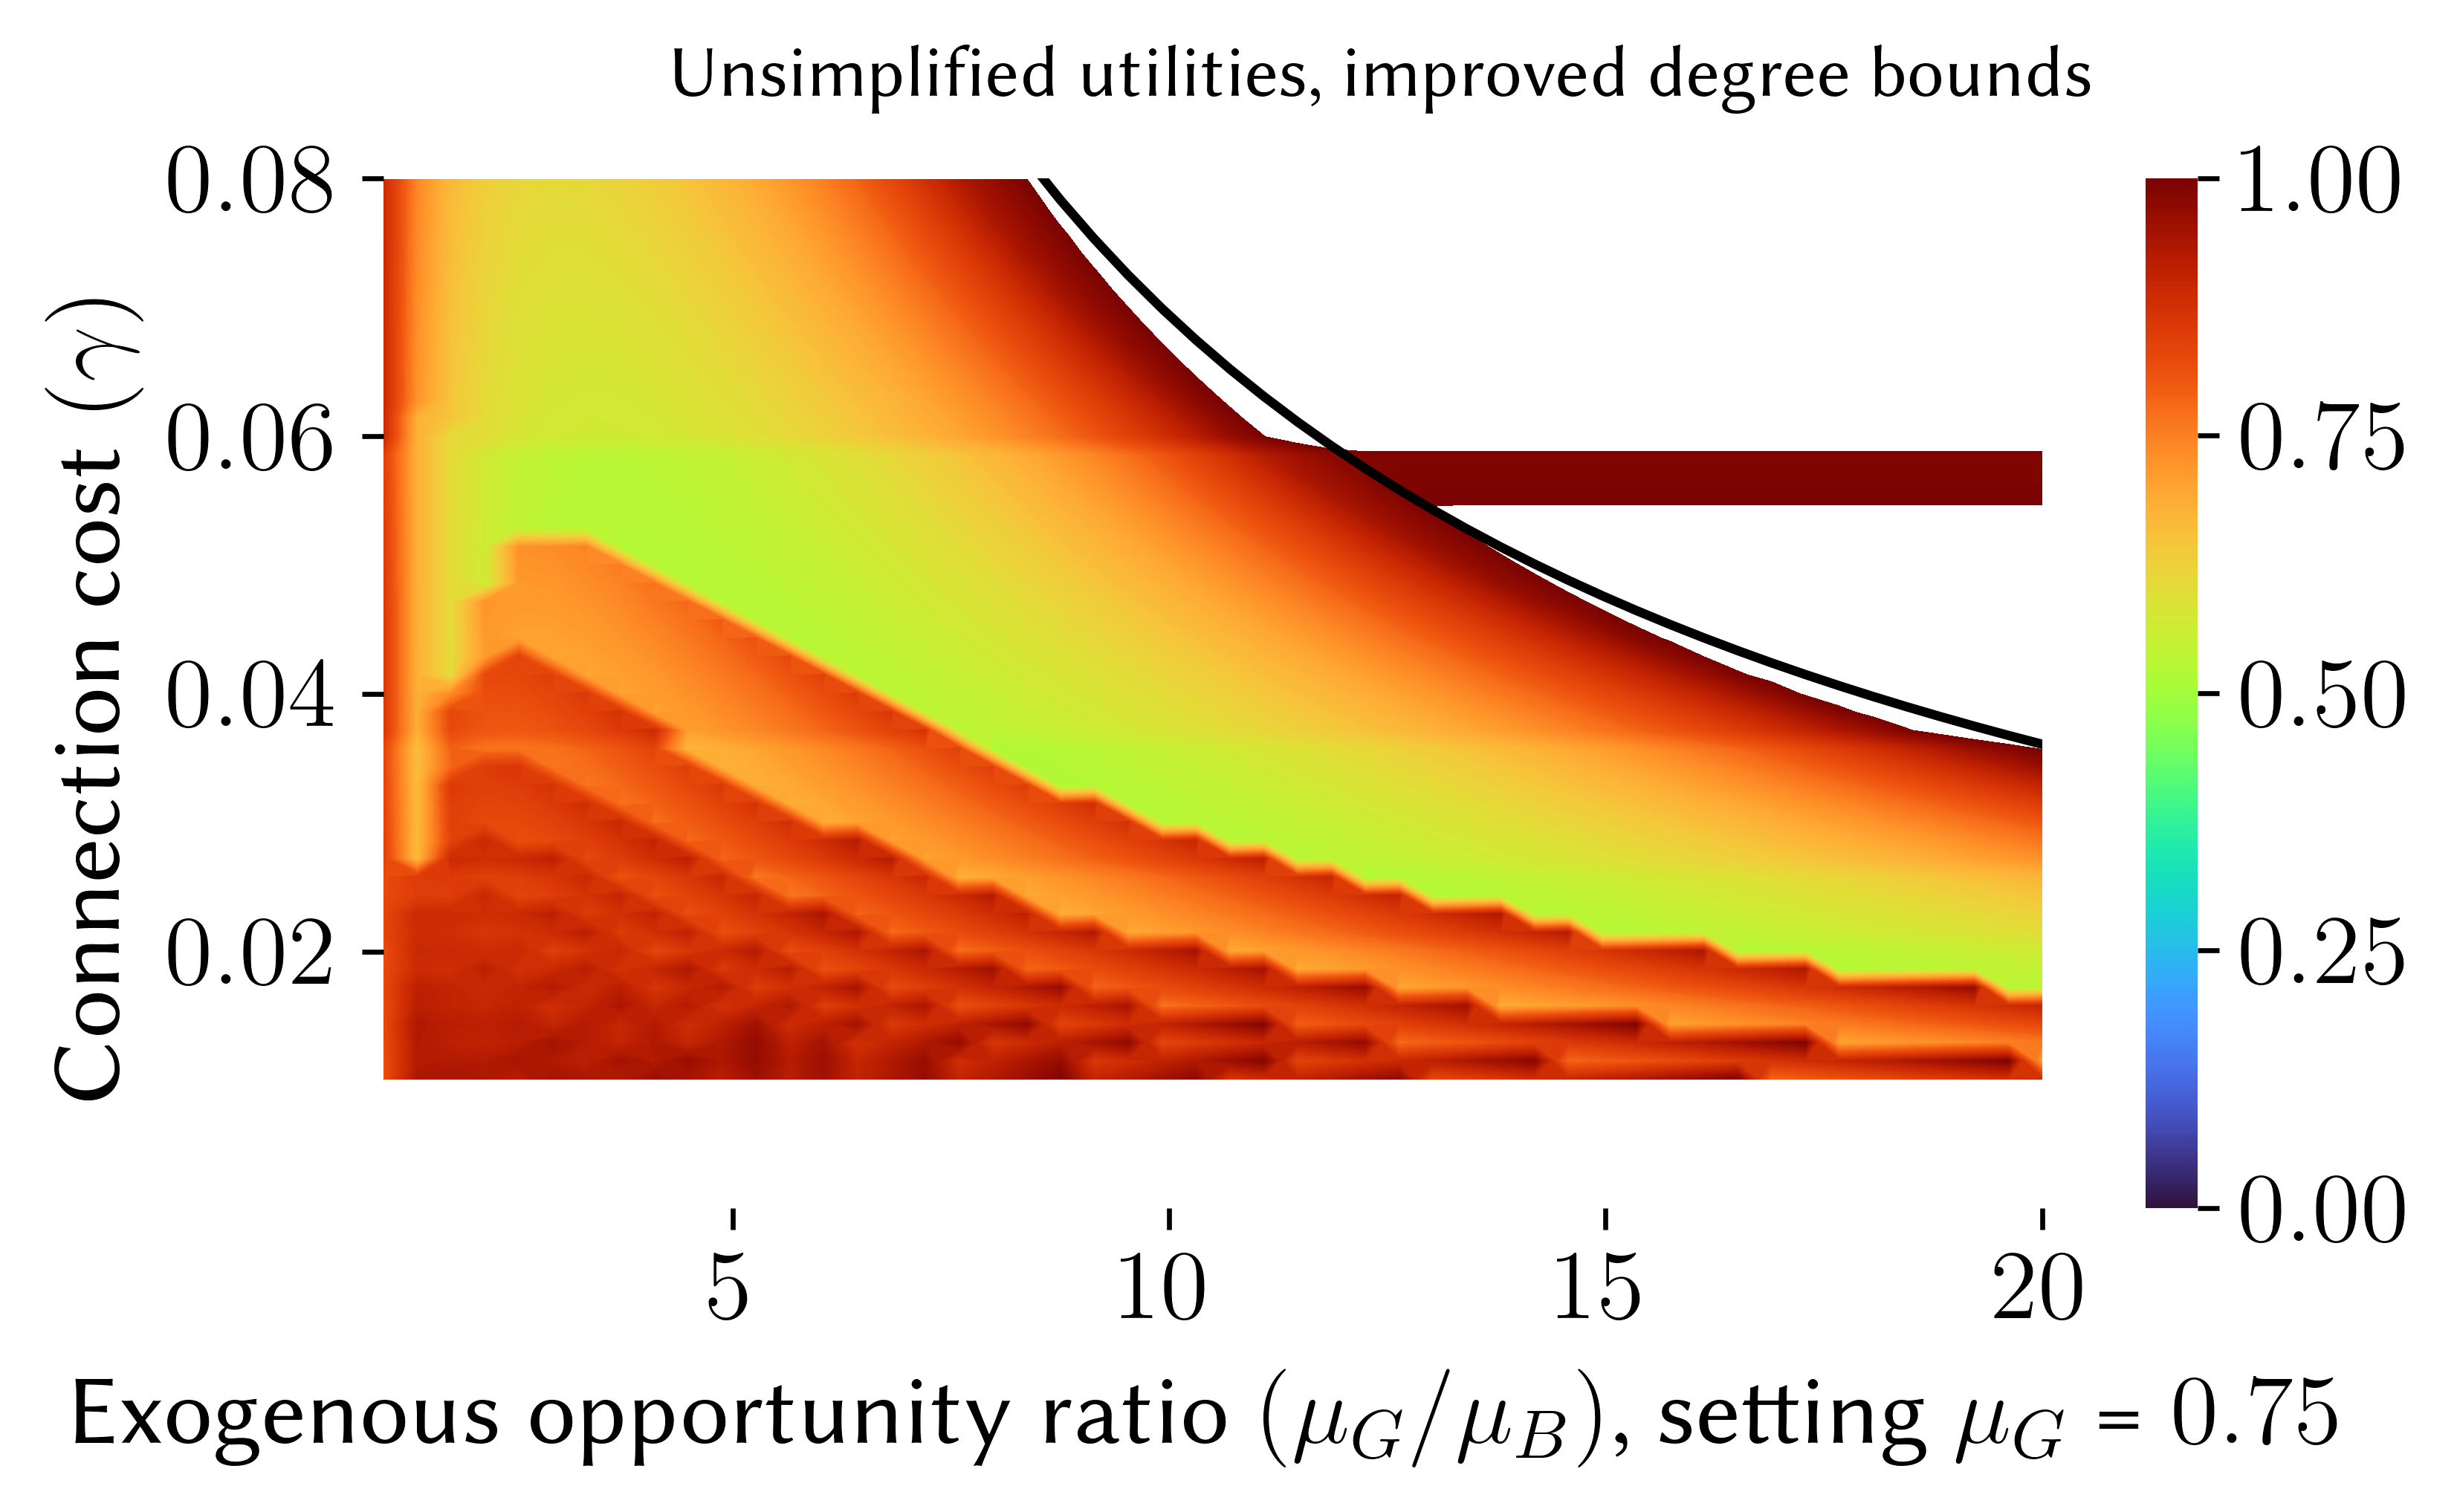

In [9]:
K = 250
fontsize = 16
poa_max = 1
levels = np.linspace(0, poa_max, K)
ticks = np.linspace(0, poa_max, 5)
tick_labs = [f"${f:.2f}$" for f in ticks]
bounds = "improved"

fig, ax = plot_contours(K, fontsize, levels, ticks, tick_labs, mu_high=0.75, gammamax=0.08, bounds=bounds, factor_max=20, util="complex", title="Unsimplified utilities, improved degree bounds")
#plt.savefig("oblivious_edge_costs_lb.png", bbox_inches='tight')

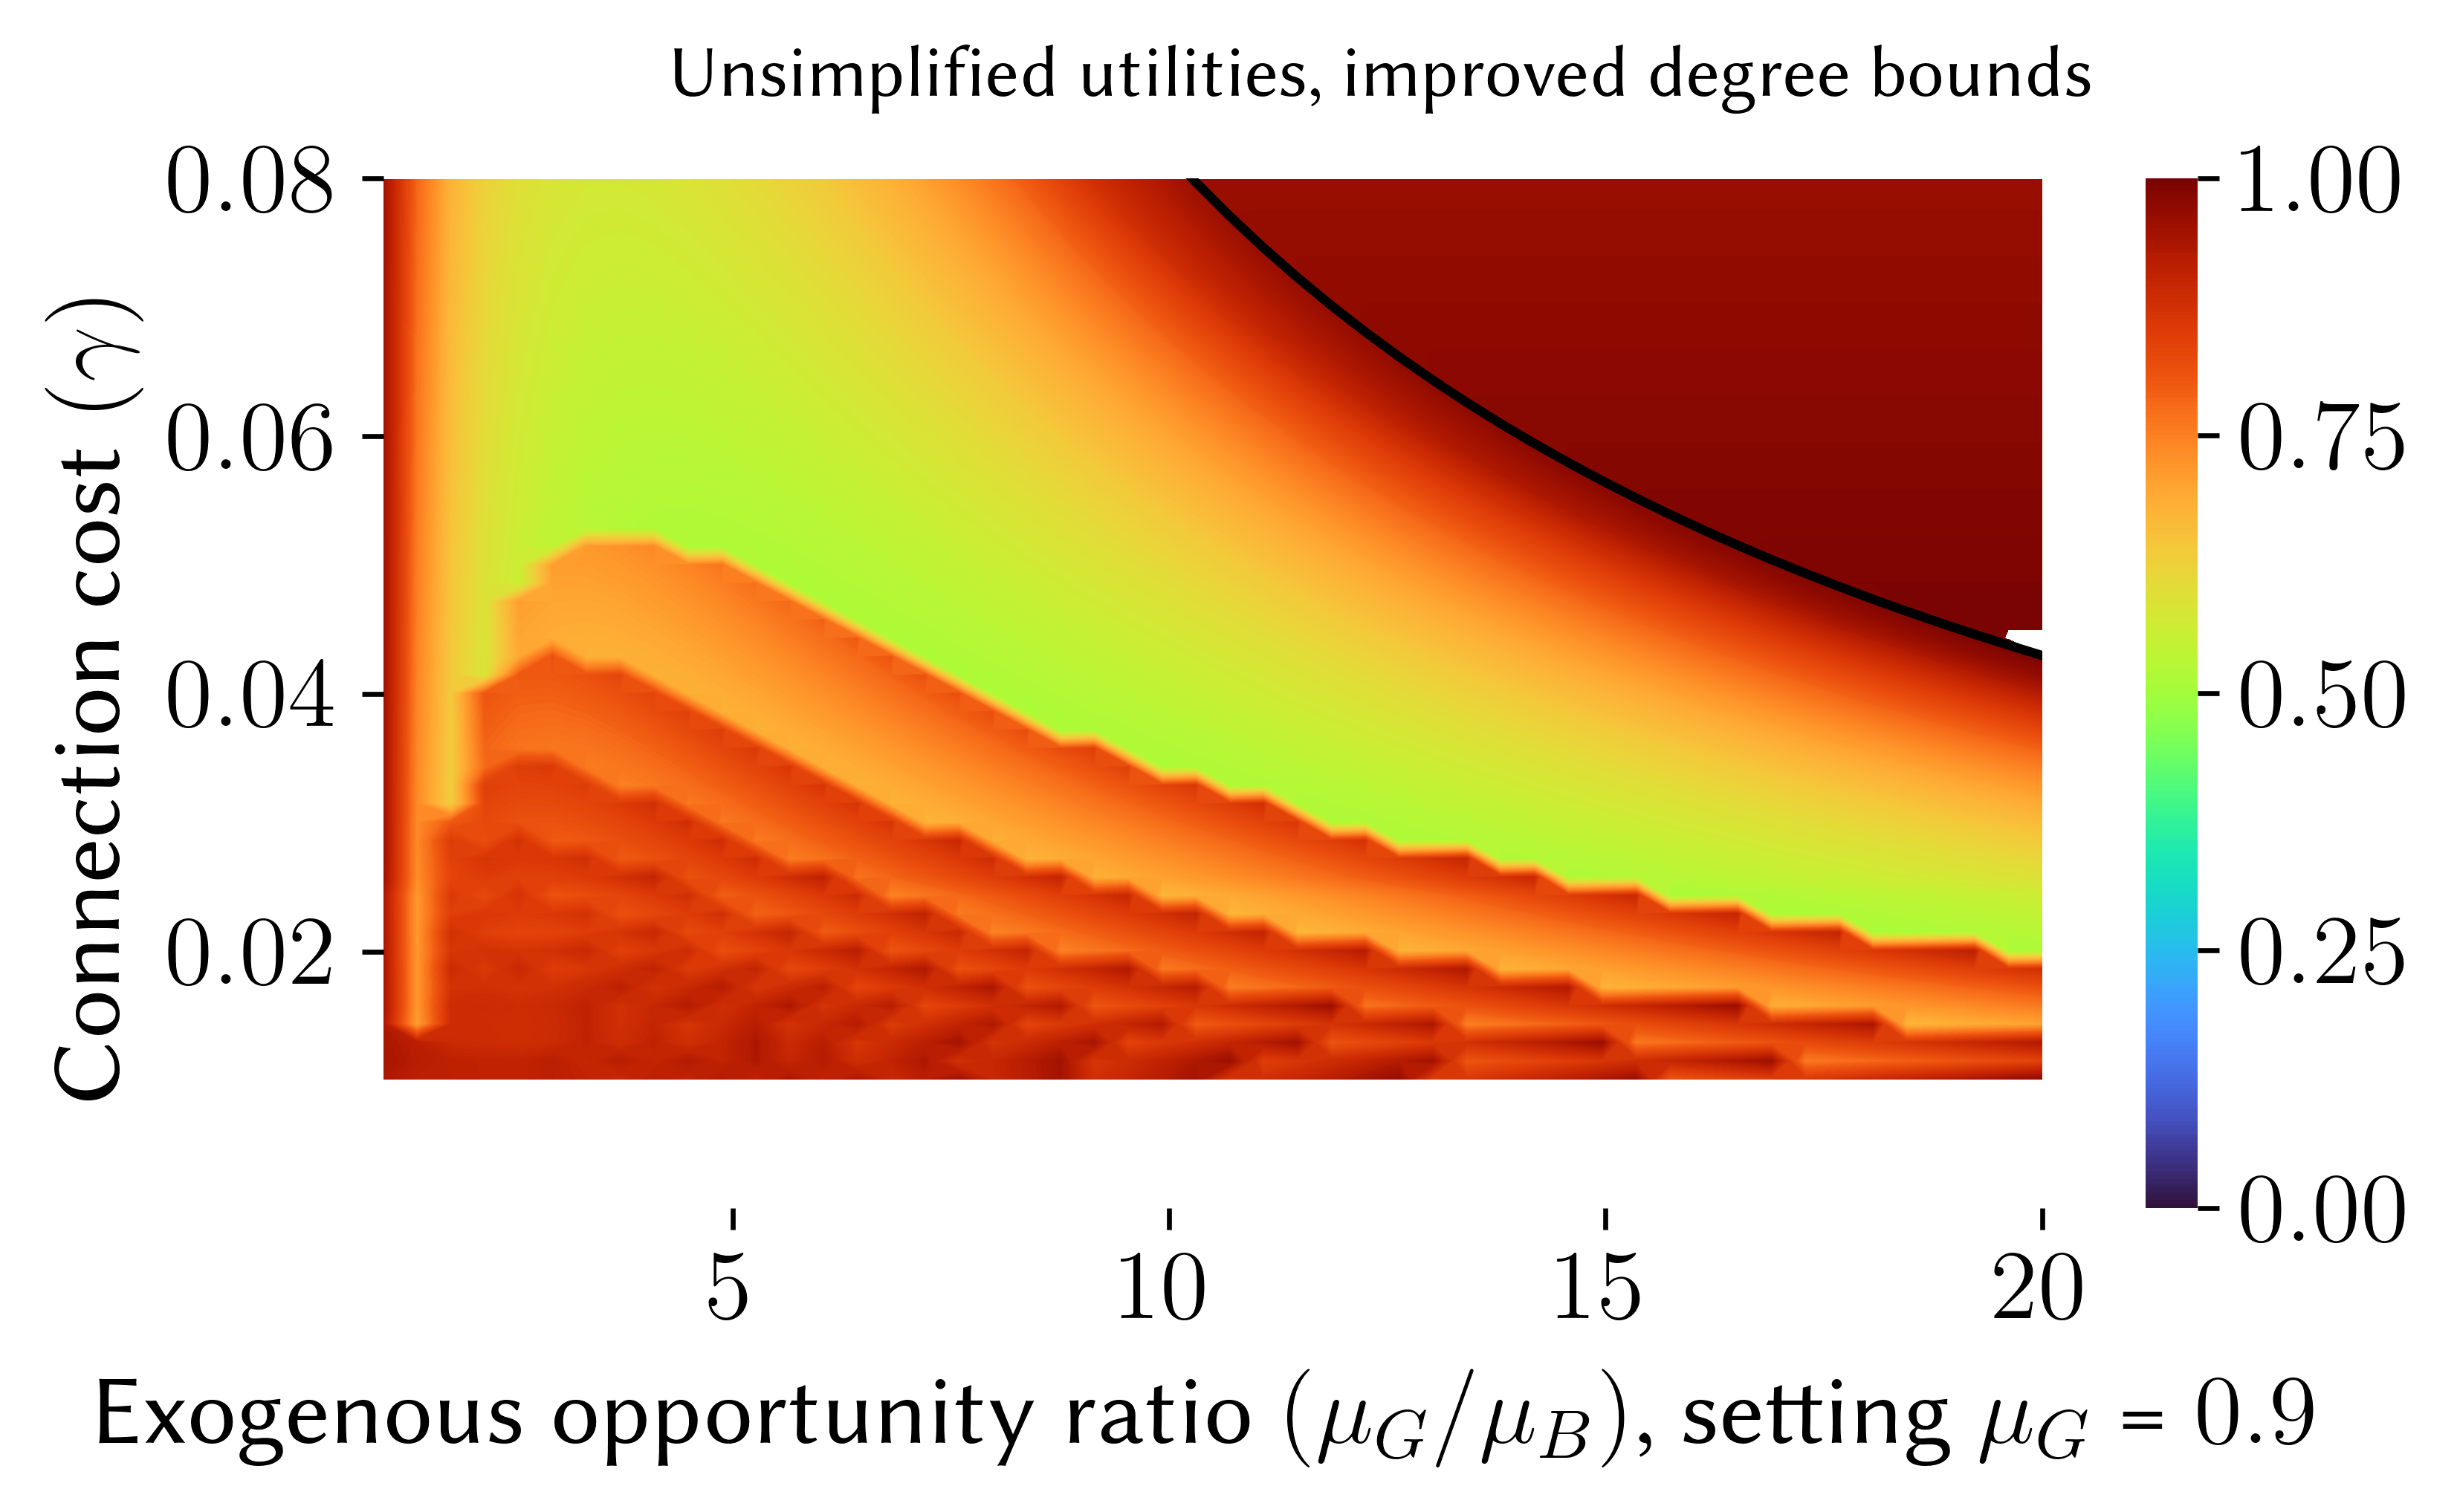

In [10]:
K = 250
fontsize = 16
poa_max = 1
levels = np.linspace(0, poa_max, K)
ticks = np.linspace(0, poa_max, 5)
tick_labs = [f"${f:.2f}$" for f in ticks]
bounds = "improved"

fig, ax = plot_contours(K, fontsize, levels, ticks, tick_labs, mu_high=0.9, gammamax=0.08, bounds=bounds, factor_max=20, util="complex", title="Unsimplified utilities, improved degree bounds")
#plt.savefig("oblivious_edge_costs_lb.png", bbox_inches='tight')

# Degree bounds on equilibria under $k=1$ edge recommendations 

In [62]:
k = 1

def feasible_sever(in2, out2, deg, deg_out, gamma):
    return (1-in2)*in2/deg * (1 - in2/deg)**(deg - k -1) * (1 - out2/deg_out)**k >= gamma

def feasible_connect(in2, out2, deg, deg_out, gamma):
    return (1-in2)*in2/(deg + 1) * (1 - in2/deg)**(deg - k) * (1 - out2/deg_out)**k <= gamma

def feasible_oneside(deg_in_upper, deg_in_lower, deg_out_upper, deg_out_lower, in2, out2, gamma):
    sever_upper = feasible_sever(in2, out2, deg_in_upper, deg_out_upper, gamma)
    sever_lower = feasible_sever(in2, out2, deg_in_lower, deg_out_upper, gamma)
    connect_upper = feasible_connect(in2, out2, deg_in_upper, deg_out_lower, gamma)
    connect_lower = feasible_connect(in2, out2, deg_in_lower, deg_out_lower, gamma)
    return sever_upper & sever_lower & connect_upper & connect_lower

def feasible_all(deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, b2, g2, gamma):
    b_feasible = feasible_oneside(deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, b2, g2, gamma)
    g_feasible = feasible_oneside(deg_g_upper, deg_g_lower, deg_b_upper, deg_b_lower, g2, b2, gamma)
    return b_feasible & g_feasible
    

In [63]:
def find_feasible_b(b2, g2, gamma, M):
    for deg_b_upper in range(M, 0, -1):
        for deg_b_lower in range(1, deg_b_upper+1):
            for deg_g_upper in range(M, 0, -1):
                for deg_g_lower in range(1, deg_g_upper+1):
                    if feasible_all(deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, b2, g2, gamma):
                        return (deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower)
def find_feasible_g(b2, g2, gamma, M):
    for deg_g_upper in range(M, 0, -1):
        for deg_g_lower in range(1, deg_g_upper+1):
            for deg_b_upper in range(M, 0, -1):
                for deg_b_lower in range(1, deg_b_upper+1):
                    if feasible_all(deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, b2, g2, gamma):
                        return (deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower)

In [75]:
g2 = 0.5
grid_size = 200
gammas = np.linspace(0.01, 0.05, grid_size)
factors = np.linspace(1, 10, grid_size)
M = 10

factors_mesh, gammas_mesh = np.meshgrid(factors, gammas)
g_lower = np.full([grid_size, grid_size], -np.inf)
g_upper = np.full([grid_size, grid_size], -np.inf)
b_lower = np.full([grid_size, grid_size], -np.inf)
b_upper = np.full([grid_size, grid_size], -np.inf)

for i in range(grid_size):
    for j in range(grid_size):
        ret = find_feasible_b(b2=b2/factors_mesh[i][j], g2=g2, gamma=gammas_mesh[i][j], M=M) 
        if ret:
            deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower = ret
            g_lower[i][j] = deg_g_lower
            g_upper[i][j] = deg_g_upper
            b_lower[i][j] = deg_b_lower
            b_upper[i][j] = deg_b_upper




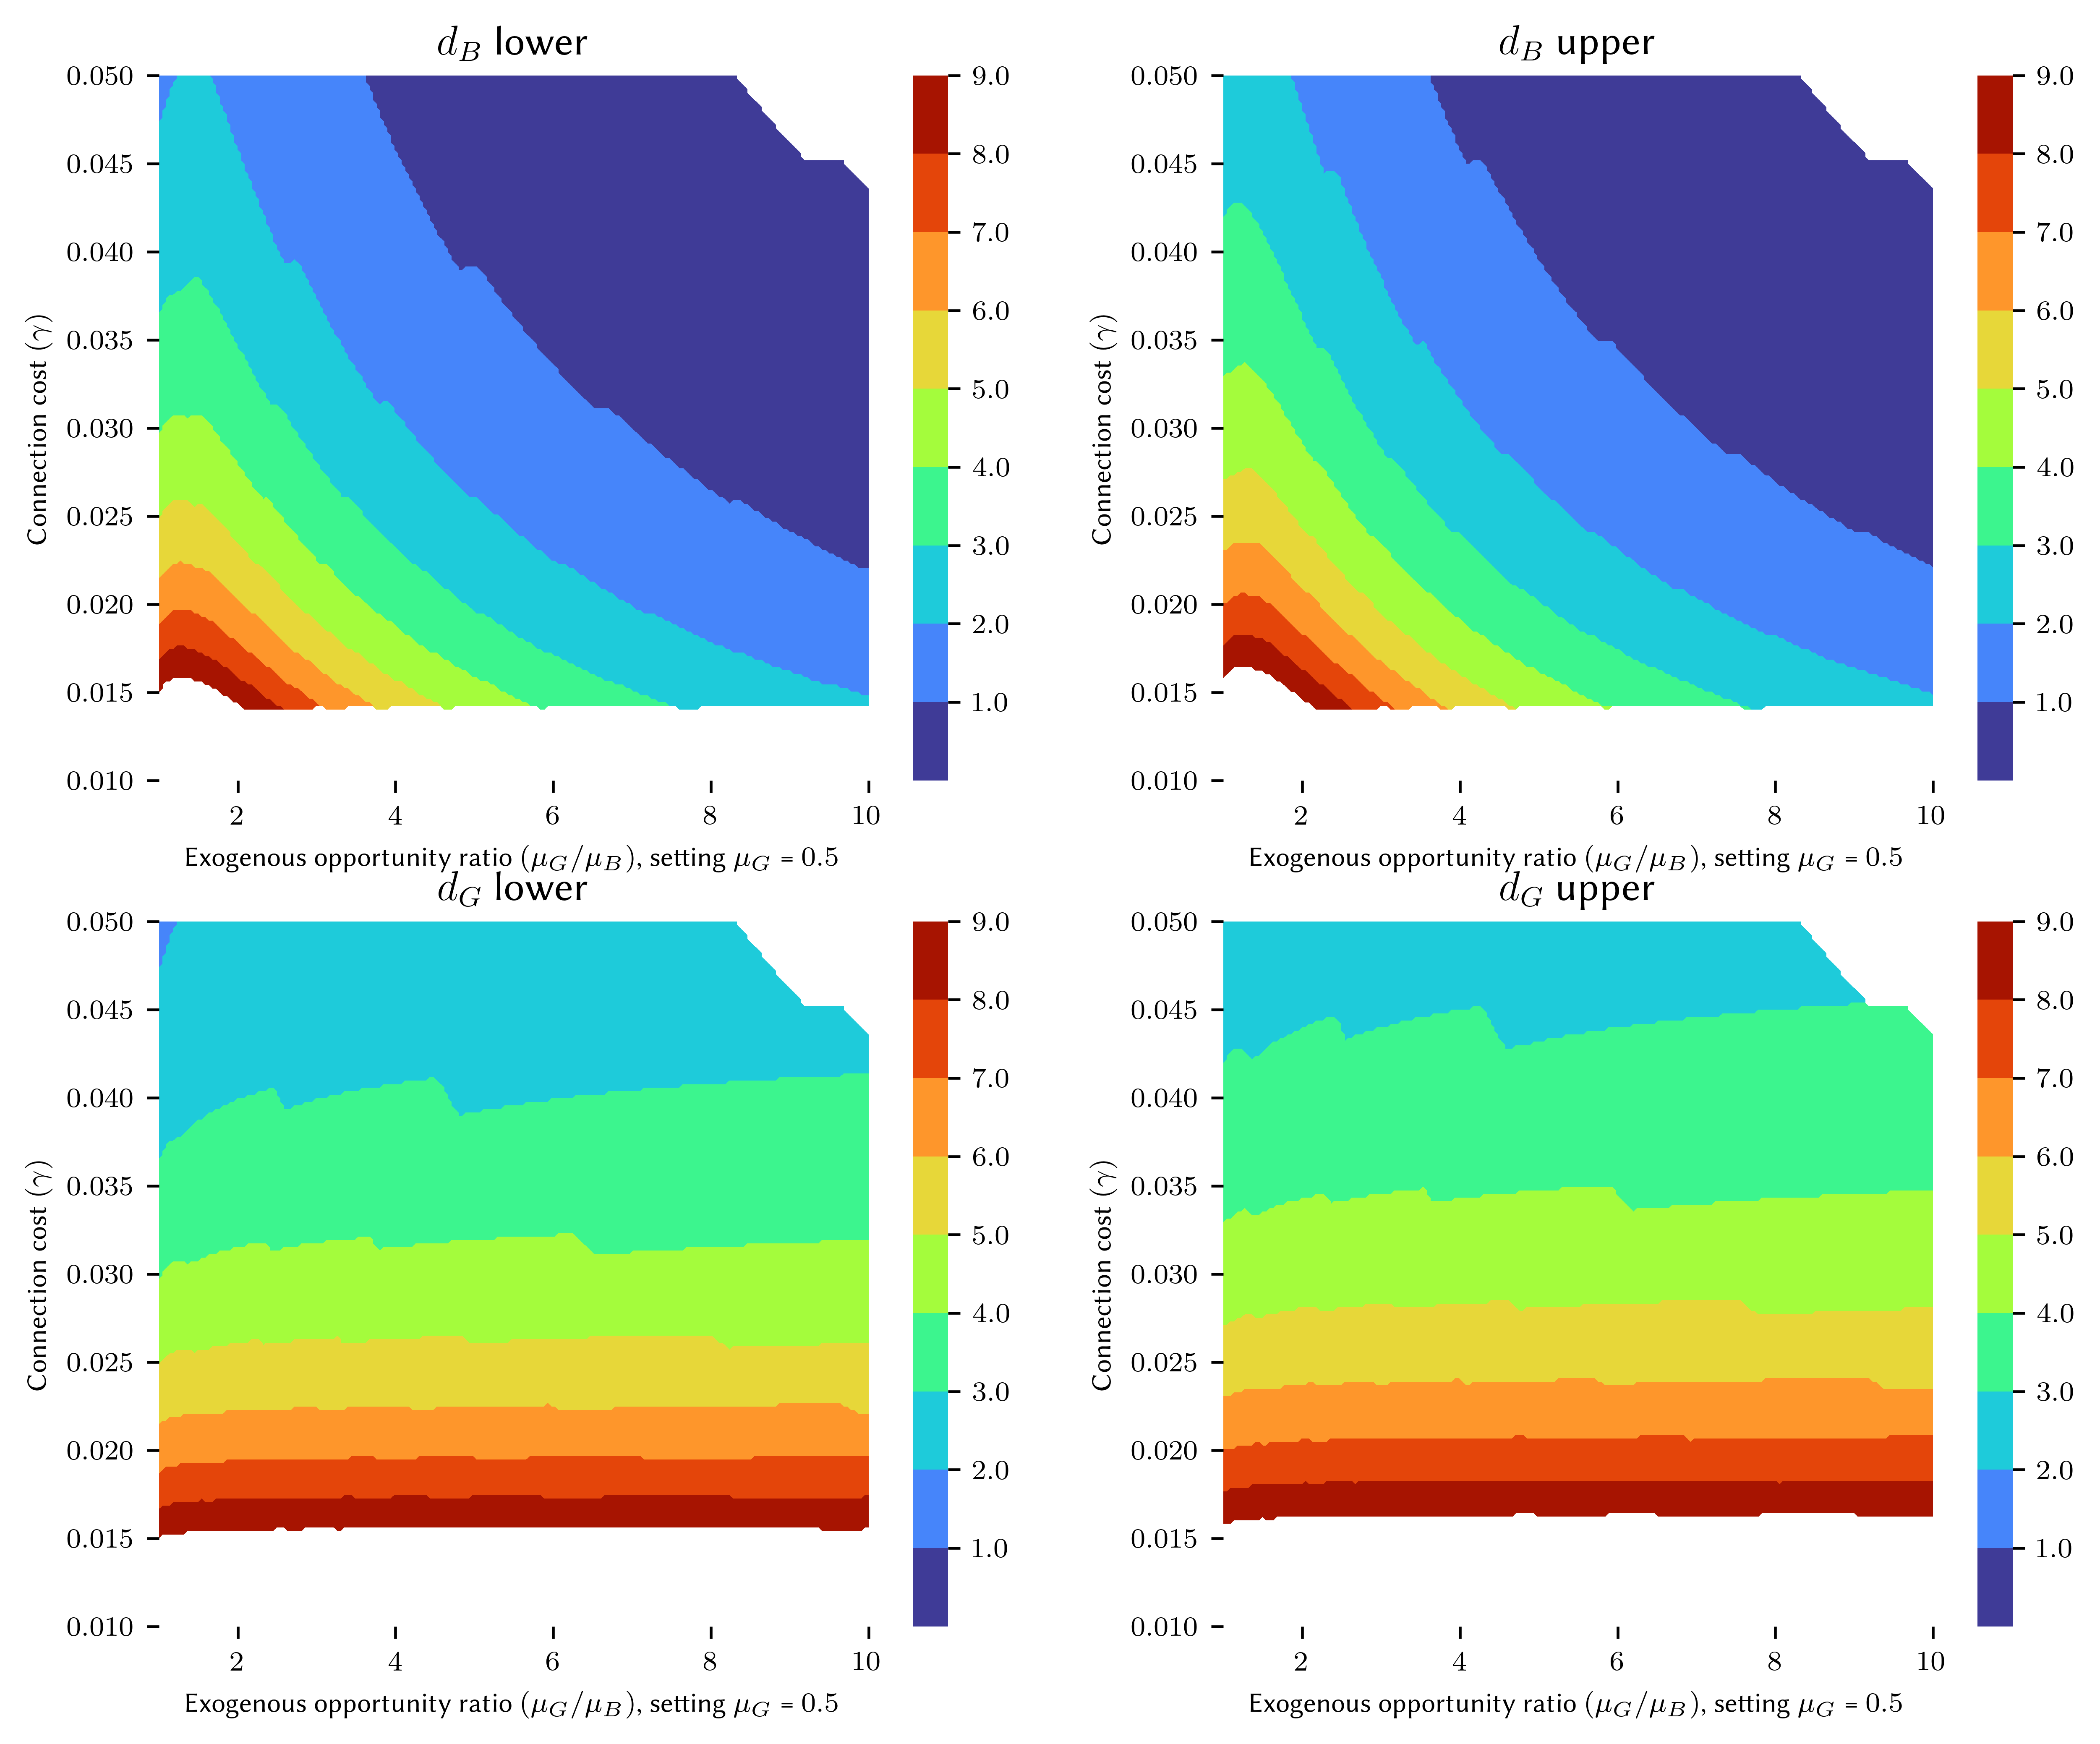

In [76]:
fontsize = 8
levels = [i for i in range(M)] #np.linspace(1, poa_max, 5)
ticks = [i for i in range(1, M)] #np.linspace(1, poa_max, 5)
tick_labs = [f"${f:.1f}$" for f in ticks]

fig, axes = plt.subplots(2,2, dpi=600, figsize=(10, 8))
degs = [b_lower, b_upper, g_lower, g_upper]
degs_title = ["$d_B$ lower", "$d_B$ upper", "$d_G$ lower", "$d_G$ upper", ]
contours = []
for i in range(4):
    ax = axes[i//2][i%2]
    contour = ax.contourf(factors_mesh, gammas_mesh, degs[i], levels=levels, cmap=cm.turbo)
    ax.set_xlabel(r"Exogenous opportunity ratio $(\mu_G / \mu_B)$, setting $\mu_G$ = " + f"${g2 * 2 - 1 + (1-g2)}$", fontsize=fontsize)
    ax.set_ylabel(r"Connection cost $(\gamma)$", fontsize=fontsize)
    ax.set_title(degs_title[i])
    cbar = fig.colorbar(contour, ticks=ticks)
    cbar.ax.set_yticklabels(tick_labs)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar.ax.tick_params(axis='both', which='major', labelsize=fontsize)
    for spine in ax.spines.values():
        spine.set_visible(False)
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

# With cross group edges, can the network reduce inequality, relative to their exogenous levels? (For all equilibria)

In [48]:


def util_g_ub(b2, g2, gamma, deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, M=10):
    return 1 - (1-g2) * (1 - g2/deg_g_lower)**(deg_g_lower - k) * (1 - g2 / deg_g_lower)**k - gamma * deg_g_lower

def util_b_lb(b2, g2, gamma, deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, M=10):
    return 1 - (1-b2) * (1 - b2/deg_b_upper)**(deg_b_upper - k) * (1 - g2 / deg_g_upper)**k - gamma * deg_b_upper


def util_ratio(b2, g2, gamma, M=10):
    ret = find_feasible_b(b2, g2, gamma, M)
    if ret:
        (deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower) = ret
        return util_g_ub(b2, g2, gamma, deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, M=10) / util_b_lb(b2, g2, gamma, deg_b_upper, deg_b_lower, deg_g_upper, deg_g_lower, M=10)
    return -np.inf

In [78]:
g2 = 0.5
grid_size = 100
gammas = np.linspace(0.01, 0.05, grid_size)
factors = np.linspace(1, 10, grid_size)
M = 10

factors_mesh, gammas_mesh = np.meshgrid(factors, gammas)
ratio = np.full([grid_size, grid_size], -np.inf)

for i in range(grid_size):
    for j in range(grid_size):
        ratio[i][j] = util_ratio(b2/factors_mesh[i][j], g2, gammas_mesh[i][j], M=10) / factors_mesh[i][j]


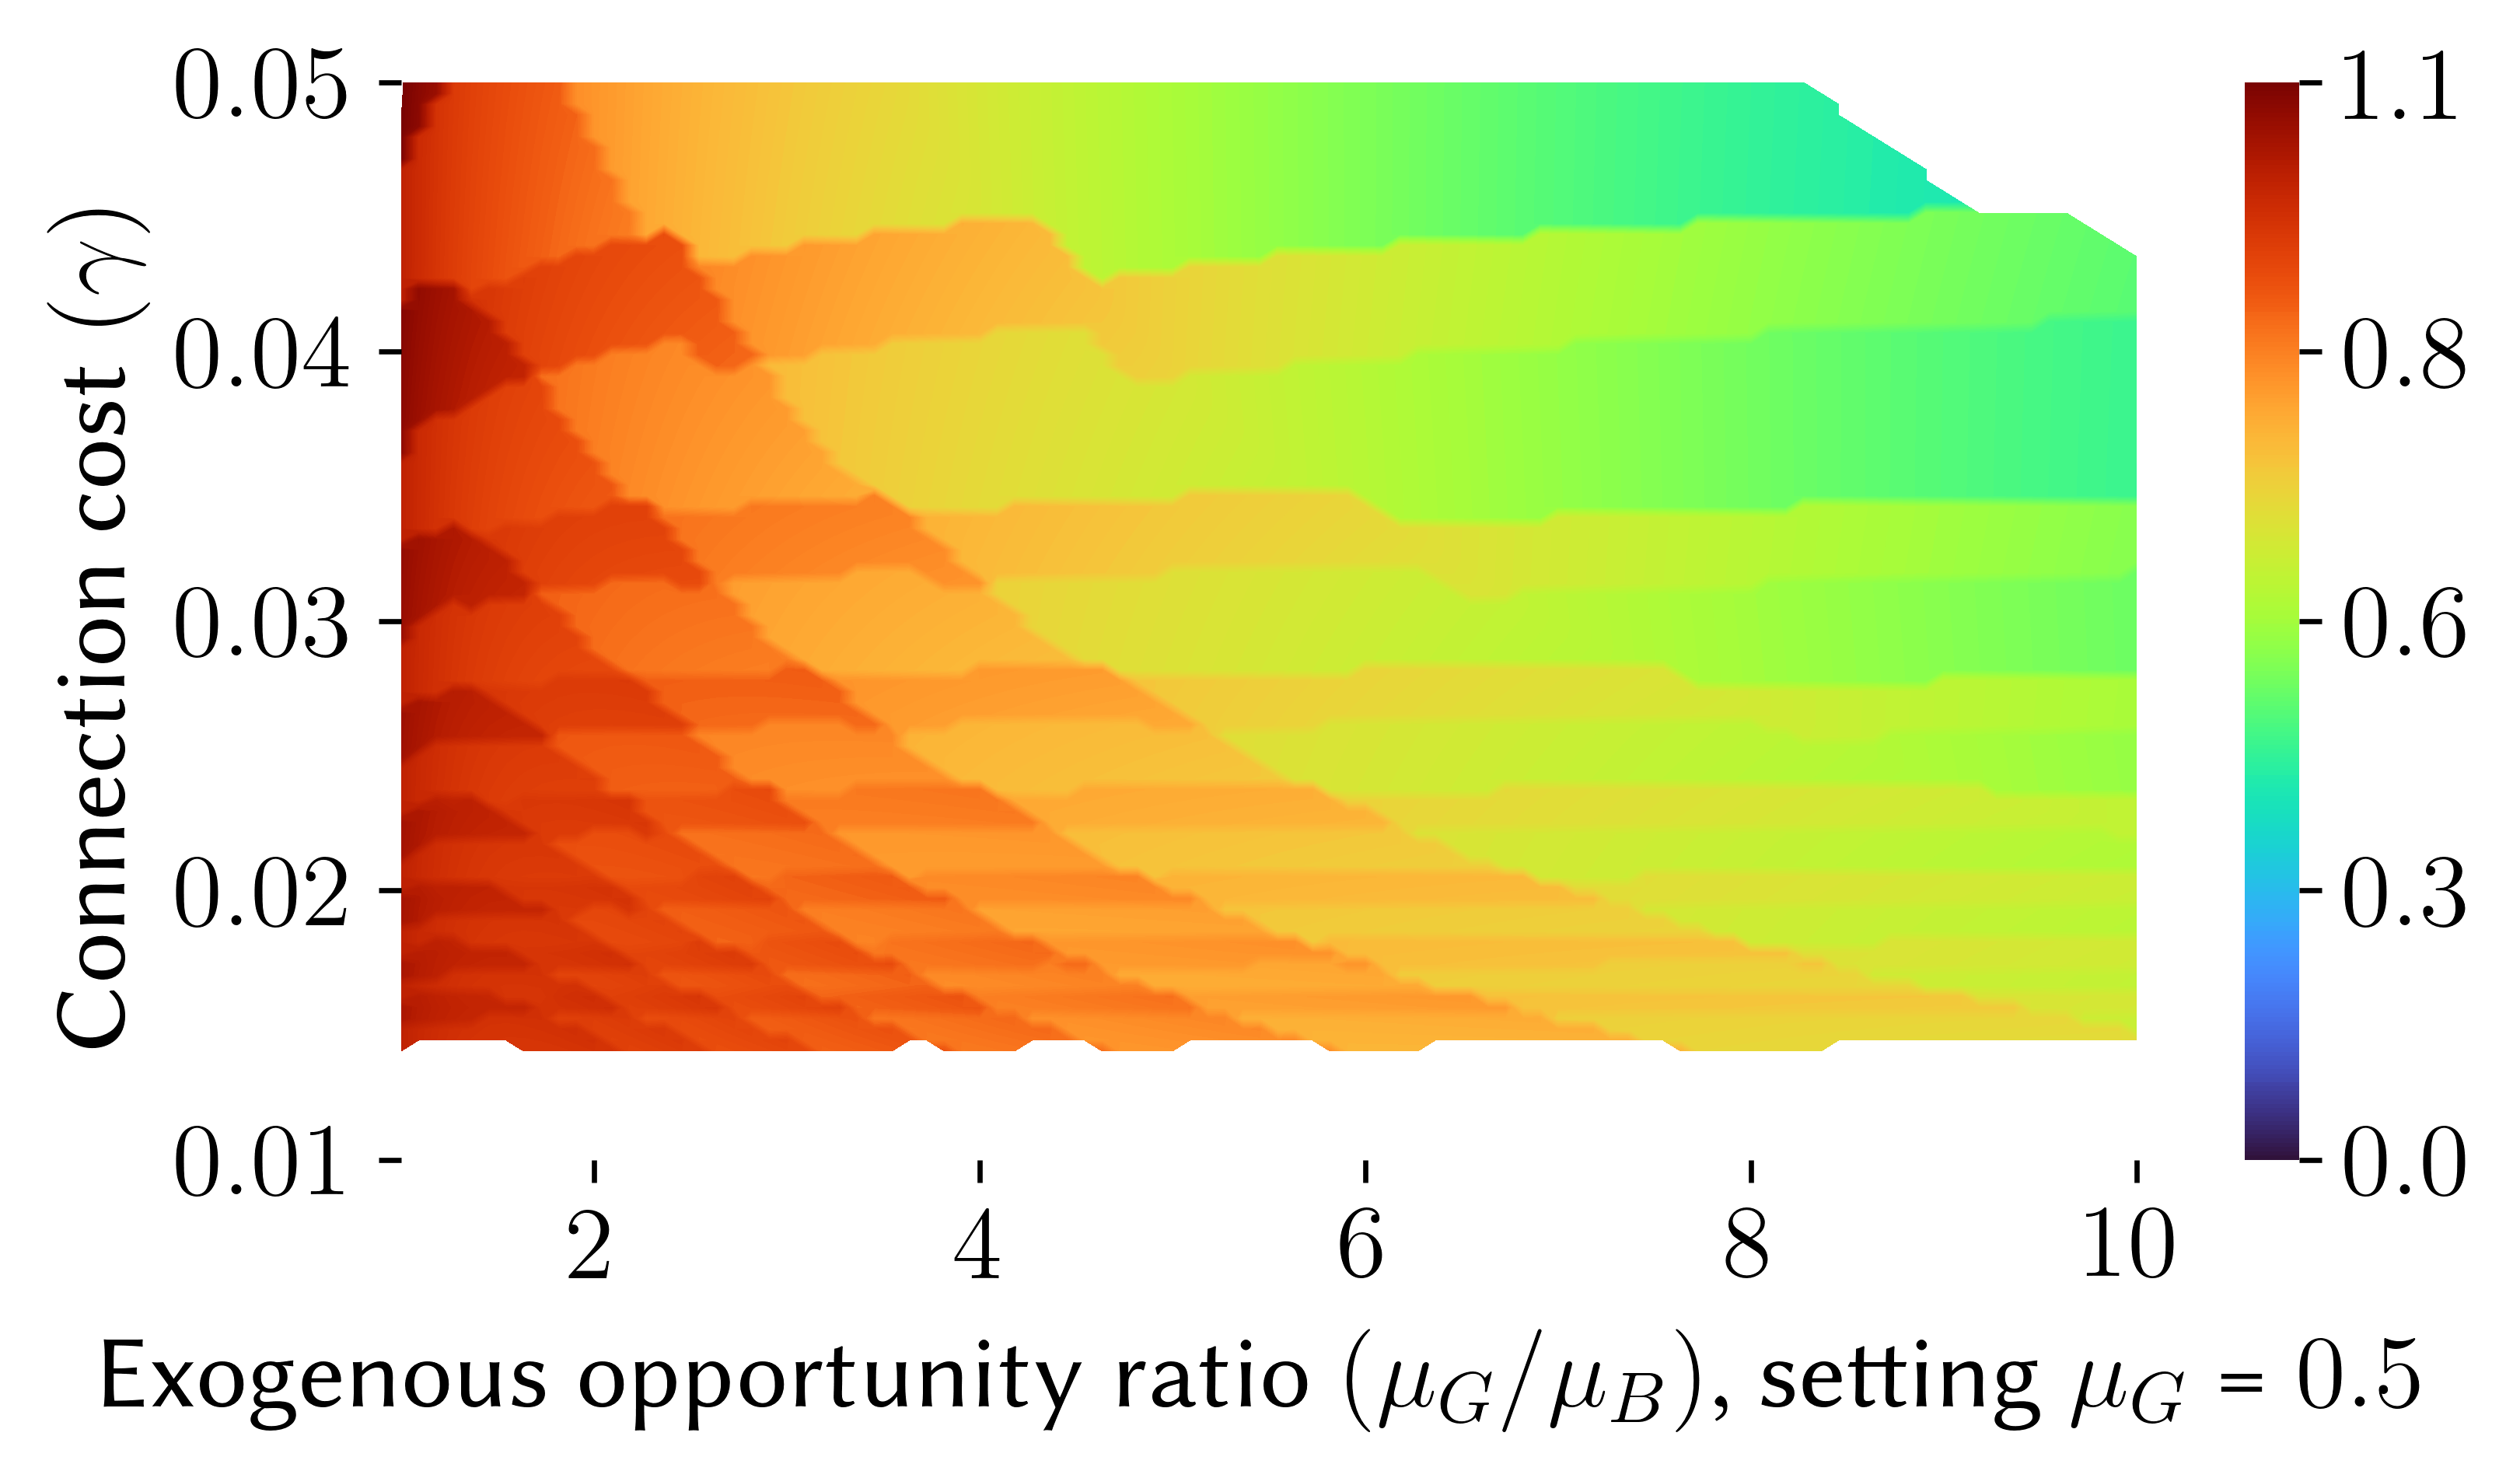

In [86]:
K = 250
fontsize = 16
poa_max = 1.1
levels = np.linspace(0., poa_max, K)
ticks = np.linspace(0., poa_max, 5)
tick_labs = [f"${f:.1f}$" for f in ticks]

fig = plt.figure(figsize=(6, 3), dpi=600)
ax = fig.add_subplot()
contour = ax.contourf(factors_mesh, gammas_mesh, ratio, levels=levels, cmap=cm.turbo)
ax.set_xlabel(r"Exogenous opportunity ratio $(\mu_G / \mu_B)$, setting $\mu_G$ = " + f"${g2 * 2 - 1 + (1-g2)}$", fontsize=fontsize)
ax.set_ylabel(r"Connection cost $(\gamma)$", fontsize=fontsize)
ax.set_title("")
cbar = fig.colorbar(contour, ticks=ticks)
cbar.ax.set_yticklabels(tick_labs)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
cbar.ax.tick_params(axis='both', which='major', labelsize=fontsize)
for spine in ax.spines.values():
    spine.set_visible(False)
for spine in cbar.ax.spines.values():
    spine.set_visible(False)
